In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle
from scipy import stats
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [182]:
# Reading the csv data
df = pd.read_csv(r'D:\TheSmartBridge\Projects\2. DrugClassification\data\drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# Univariate analysis

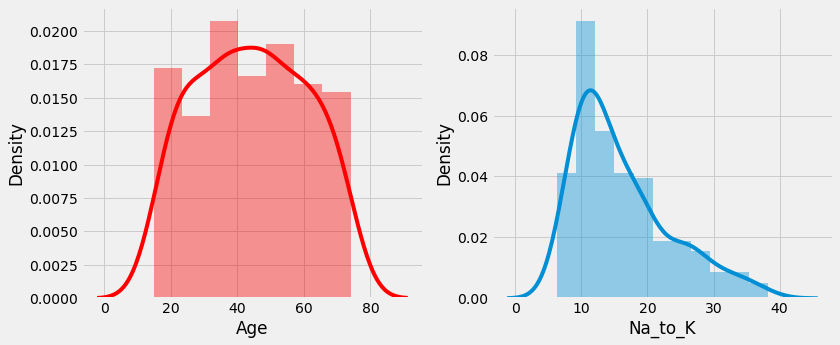

In [183]:
# Checking the distribution (normal or skewed)

plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df['Age'],color='r')
plt.subplot(122)
sns.distplot(df['Na_to_K'])
plt.show()

In [184]:
# Creating a data frame with categorical features for following visualization

df_cat = df.select_dtypes(include='object')
df_cat.head()

,Sex,BP,Cholesterol,Drug
0,F,HIGH,HIGH,DrugY
1,M,LOW,HIGH,drugC
2,M,LOW,HIGH,drugC
3,F,NORMAL,HIGH,drugX
4,F,LOW,HIGH,DrugY


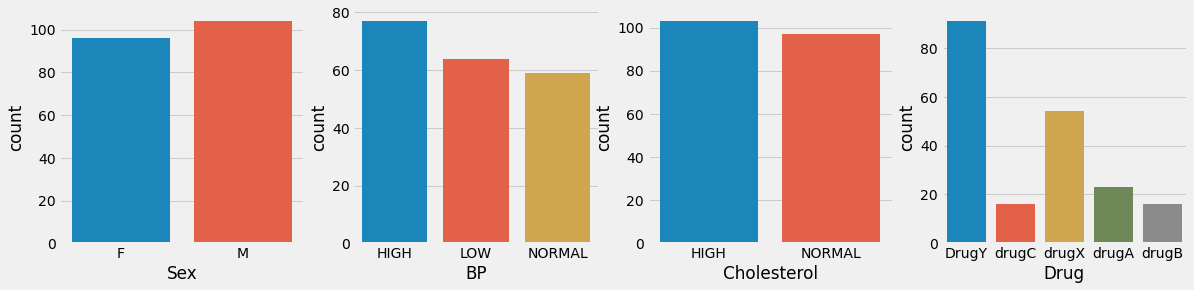

In [185]:
# Visualizing the count of categorical variable.

plt.figure(figsize=(18,4))
for i,j in enumerate(df_cat):
    plt.subplot(1,4,i+1)
    sns.countplot(df[j])   

# Bivariate analysis

<AxesSubplot:xlabel='Drug', ylabel='count'>

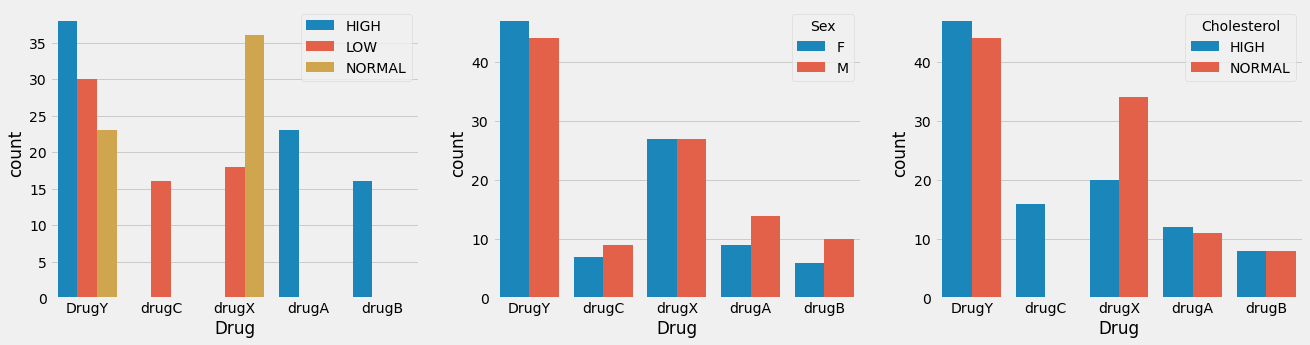

In [186]:
# Visualizing the relation between drug, BP, sex & cholesterol

plt.figure(figsize=(20,5))
plt.subplot(131)
sns.countplot(df['Drug'],hue=df['BP'])
plt.legend(loc='upper right')
plt.subplot(132)
sns.countplot(df['Drug'],hue=df['Sex'])
plt.subplot(133)
sns.countplot(df['Drug'],hue=df['Cholesterol'])

In [187]:
# Creating a new column Age_. This column shows the categorized age.

df['Age_'] = ['15-30' if x<=30 else '30-50' if x>30 and x<=50 else '50-75' for x in df['Age']]
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Age_
0,23,F,HIGH,HIGH,25.355,DrugY,15-30
1,47,M,LOW,HIGH,13.093,drugC,30-50
2,47,M,LOW,HIGH,10.114,drugC,30-50
3,28,F,NORMAL,HIGH,7.798,drugX,15-30
4,61,F,LOW,HIGH,18.043,DrugY,50-75


In [188]:
# Finding the relation between categorized age and drug

pd.crosstab(df['Age_'],[df['Drug']])

Drug,DrugY,drugA,drugB,drugC,drugX
Age_,,,,,
15-30,24,6,0,5,13
30-50,33,17,0,7,22
50-75,34,0,16,4,19


In [189]:
# Removing the Age_ column

df.drop('Age_',axis=1,inplace=True)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# Multivariate Analysis

<AxesSubplot:xlabel='Drug', ylabel='Na_to_K'>

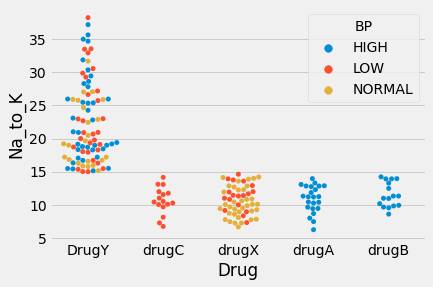

In [190]:
sns.swarmplot(df['Drug'],df['Na_to_K'],hue=df['BP'])

# DrugC is used for low BP patient, DrugY is used on patients having Na_to_K > 15.

# Descriptive analysis

In [191]:
df.describe(include='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,DrugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


# Data Pre-Processing

In [192]:
# Shape of csv data
df.shape

(200, 6)

In [193]:
# Finding null values
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [194]:
# Checking the information of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


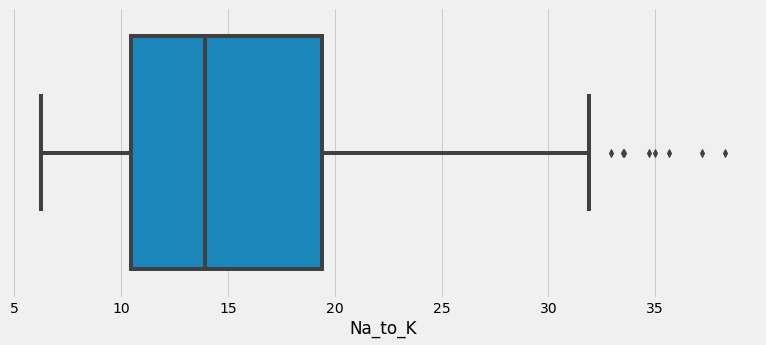

In [195]:
# Finding outliers

plt.figure(figsize=(12,5))
sns.boxplot(df['Na_to_K'])
plt.show()

In [196]:
# From the above plot age column is normally distributed. Na_to_k is right skewed (mean>mode). To overcome skewness transformation techniques can be used.

print(stats.mode(df['Na_to_K']))
print(np.mean(df['Na_to_K']))

ModeResult(mode=array([12.006]), count=array([2]))
16.08448499999999


In [197]:
# Na_to_K has 8 outliers. In this project we are not going to handle outliers. Most of the classification algorithms are not sensitive to outliers.

q1 = np.quantile(df['Na_to_K'],0.25)
q3 = np.quantile(df['Na_to_K'],0.75)

IQR = q3-q1

upper_bound = q3+(1.5*IQR)
lower_bound = q1-(1.5*IQR)

print('q1 :',q1)
print('q3 :',q3)
print('IQR :',IQR)
print('Upper Bound :',upper_bound)
print('Lower Bound :',lower_bound)
print('Skewed data :',len(df[df['Na_to_K']>upper_bound]))
print('Skewed data :',len(df[df['Na_to_K']<lower_bound]))

q1 : 10.4455
q3 : 19.38
IQR : 8.9345
Upper Bound : 32.78175
Lower Bound : -2.9562500000000007
Skewed data : 8
Skewed data : 0


In [198]:
# To handle outliers transformation techniques are used.

def transformationPlot(feature):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.distplot(feature)
    plt.subplot(1,2,2)
    stats.probplot(feature,plot=plt)

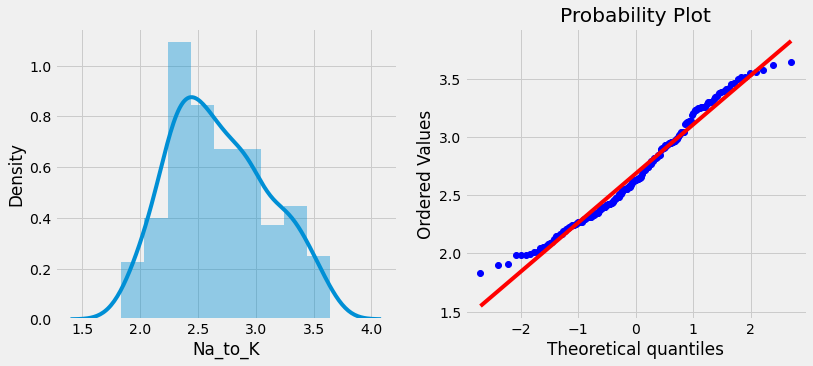

In [199]:
transformationPlot(np.log(df['Na_to_K']))

In [200]:
df['Na_to_K']=np.log(df['Na_to_K'])

# Encoding- Converting categorical to numerical

In [201]:
# Replacing low, normal & high with 0, 1 & 2...

df['BP'] = [0 if x=='LOW' else 1 if x=='NORMAL' else 2 for x in df['BP']]

In [202]:
# Replacing normal and high cholesterol with 0 & 1

df['Cholesterol'] = [0 if x=='NORMAL' else 1 for x in df['Cholesterol']]

In [203]:
# Replacing female and male with 0 & 1

df['Sex'] = [0 if x=='F' else 1 for x in df['Sex']]

In [204]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,3.232976,DrugY
1,47,1,0,1,2.572078,drugC
2,47,1,0,1,2.313921,drugC
3,28,0,1,1,2.053867,drugX
4,61,0,0,1,2.892758,DrugY


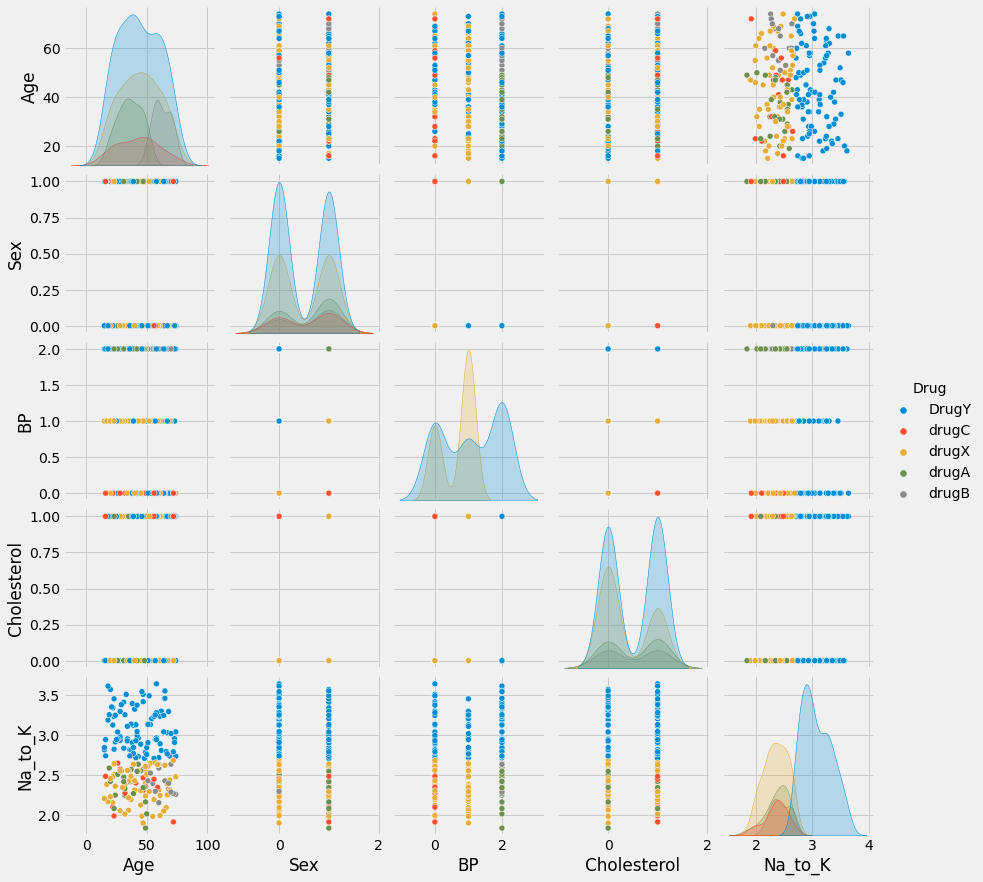

In [205]:
# With the help of pairplot we find the correct classification algorithms

sns.pairplot(df,hue='Drug')

In [206]:
x = df.drop('Drug',axis=1)
x.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,2,1,3.232976
1,47,1,0,1,2.572078
2,47,1,0,1,2.313921
3,28,0,1,1,2.053867
4,61,0,0,1,2.892758


In [207]:
y = df['Drug']
y.head()

0    DrugY
1    drugC
2    drugC
3    drugX
4    DrugY
Name: Drug, dtype: object

In [208]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [209]:
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_test.shape))
print('Shape of y_test {}'.format(y_test.shape))

Shape of x_train (140, 5)
Shape of y_train (140,)
Shape of x_test (60, 5)
Shape of y_test (60,)


# Model Building

In [210]:
def decisionTree(x_train, x_test, y_train, y_test):
    dt=DecisionTreeClassifier()
    dt.fit(x_train,y_train)
    yPred = dt.predict(x_test)
    print('***DecisionTreeClassifier***')
    print('Confusion matrix')
    print(confusion_matrix(y_test,yPred))
    print('Classification report')
    print(classification_report(y_test,yPred))

In [211]:
def randomForest(x_train, x_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(x_train,y_train)
    yPred = rf.predict(x_test)
    print('***RandomForestClassifier***')
    print('Confusion matrix')
    print(confusion_matrix(y_test,yPred))
    print('Classification report')
    print(classification_report(y_test,yPred))

In [212]:
def KNN(x_train, x_test, y_train, y_test):
    knn = KNeighborsClassifier()
    knn.fit(x_train,y_train)
    yPred = knn.predict(x_test)
    print('***KNeighborsClassifier***')
    print('Confusion matrix')
    print(confusion_matrix(y_test,yPred))
    print('Classification report')
    print(classification_report(y_test,yPred))

In [213]:
def xgboost(x_train, x_test, y_train, y_test):
    xg = GradientBoostingClassifier()
    xg.fit(x_train,y_train)
    yPred = xg.predict(x_test)
    print('***GradientBoostingClassifier***')
    print('Confusion matrix')
    print(confusion_matrix(y_test,yPred))
    print('Classification report')
    print(classification_report(y_test,yPred))

In [214]:
def compareModel(x_train, x_test, y_train, y_test):
    decisionTree(x_train, x_test, y_train, y_test)
    print('-'*100)
    randomForest(x_train, x_test, y_train, y_test)
    print('-'*100)
    KNN(x_train, x_test, y_train, y_test)
    print('-'*100)
    xgboost(x_train, x_test, y_train, y_test)

In [215]:
compareModel(x_train, x_test, y_train, y_test)

***DecisionTreeClassifier***
Confusion matrix
[[25  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0 15]]
Classification report
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        25
       drugA       0.78      1.00      0.88         7
       drugB       1.00      0.67      0.80         6
       drugC       1.00      1.00      1.00         7
       drugX       1.00      1.00      1.00        15

    accuracy                           0.97        60
   macro avg       0.96      0.93      0.93        60
weighted avg       0.97      0.97      0.97        60

----------------------------------------------------------------------------------------------------
***RandomForestClassifier***
Confusion matrix
[[25  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0 15]]
Classification report
              precision    recall  f1-score   support

       DrugY       1.00      1.00    

In [ ]:
# Decision tree and Random forest performs well

In [217]:
from sklearn.model_selection import cross_val_score

In [218]:
# Random forest model is selected

rf = RandomForestClassifier()
rf.fit(x_train,y_train)
yPred = rf.predict(x_test)

In [220]:
f1_score(yPred,y_test,average='weighted')

0.9679166666666668

In [221]:
cv = cross_val_score(rf,x,y,cv=5)

In [222]:
np.mean(cv)

0.985

In [32]:
pickle.dump(rf,open('model.pkl','wb'))